In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from hist_utils import calc_one_chi2, HistMaker1d, geom_avg1d, ratio_err, symmetrize
from hist_template import set_opt_text, set_th1, set_pad
from fitting import covariance_fit_scipy
from plotting import plotComparison, xAxisProperties
from ROOT import TFile, TH1, TF1, TCanvas, gStyle, TLegend
import math
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
gStyle.SetOptStat(0)

same_sign_symm = False
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = True
range_used = range(0,12)

if read_saved:
    if event_mixing:
        if ag1580ag:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d_ag1580ag"
        else:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d"
    else:
        if ag1580ag:
           # DIR_NAME = "results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr_vertexsim_epem"
            DIR_NAME = "results_1702372287"
        else:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
ag1580ag = True

if ag1580ag:
    ekin = 1580
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
   # filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
    filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
        filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
        filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
        filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_swapRandomly.dat"
        filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_swapRandomly.dat"
else:
    ekin = 1230
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "088_090_ag123ag_2500A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_np.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"


frame = Frame.HX

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMaker1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMaker1d(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMaker1d(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists  ()
histMakerData_pp = HistMaker1d(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMaker1d(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_np_mix = HistMaker1d(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMaker1d(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMaker1d(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_4pi_heli0 = HistMaker1d(filename_MC_rho_4pi_heli0, "_MC_rho_4pi_heli0", bins, frame, ekin)
histMakerMC_rho_4pi_heli1 = HistMaker1d(filename_MC_rho_4pi_heli1, "_MC_rho_4pi_heli1", bins, frame, ekin)
histMakerMC_rho_heli0 = HistMaker1d(filename_MC_rho_heli0, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli0_pp = HistMaker1d(filename_MC_rho_heli0_pp, "_MC_rho_heli0_pp", bins, frame, ekin)
histMakerMC_rho_heli0_nn = HistMaker1d(filename_MC_rho_heli0_nn, "_MC_rho_heli0_nn", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMaker1d(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_rho = histMakerMC_rho_heli0
histMakerMC_pi0 = HistMaker1d(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMaker1d(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMaker1d("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMaker1d("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        return histMakerMC_pi0 if hist_index < 3 else histMakerMC_rho

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
ERROR! Wrong values:  6047.161932249999 81.87716196000001 622.10835241 5343.186028409999
77.7635 -9.0486 -24.9421 73.0971
ERROR! Wrong values:  1594.1094316899998 86.30781604 82.45366415999999 1425.34941444
39.9263 -9.2902 9.0804 37.7538
ERROR! Wrong values:  3369.1988070400002 1899.1553884900004 206.20672800999998 1263.83805025
58.0448 -43.5793 14.3599 35.5505
ERROR! Wrong values:  28.99284025 11.71213729 3.9652756900000004 13.31593081
5.3845 3.4223 -1.9913 3.6491
ERROR! Wrong values:  4432.12410564 850.49806689 981.93236164 2599.6945638400002
66.5742 29.1633 31.3358 50.9872
ERROR! Wrong values:  136616.726689 359.15556196 1255.3841059599997 135002.23290225
369.617 18.9514 35.4314 367.4265
ERROR! Wrong values:  5186.10261316 34.67796544 7.1102222500000005 5144.31783121
72.0146 5.8888 2.6665 71.7239
ERROR! Wrong values:  5886.050464360001 3159.18188356 697.73637609 2029.1331068100003
76.7206 -56.2066 26.4147 45.0459
ERROR! Wrong values:  2820.7

Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_data_

Info in <TCanvas::Print>: gif file results_1702372287/histsData_np.gif has been created


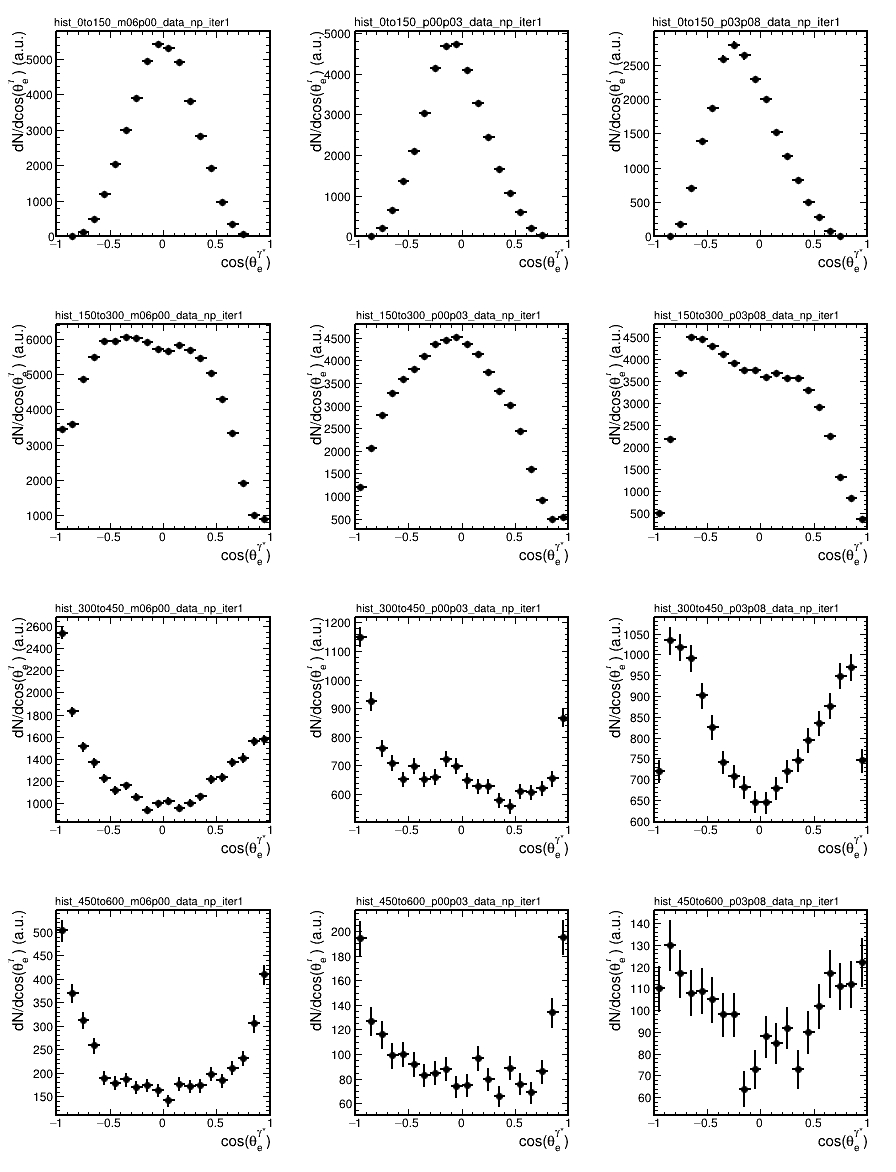

In [4]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData_np[0]):
    pad = can4.cd(i+1)
    set_pad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData_np.gif')

Info in <TCanvas::Print>: gif file results_1702372287/base_hists_pi0_MC.gif has been created


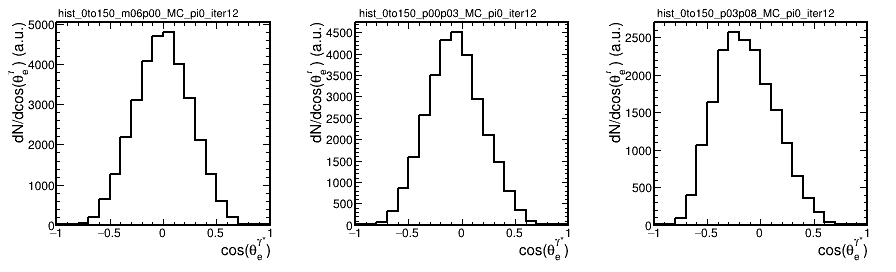

In [5]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        pad = can3.cd(i+1)
        set_pad(pad)

        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_1702372287/base_hists_rho_MC.gif has been created


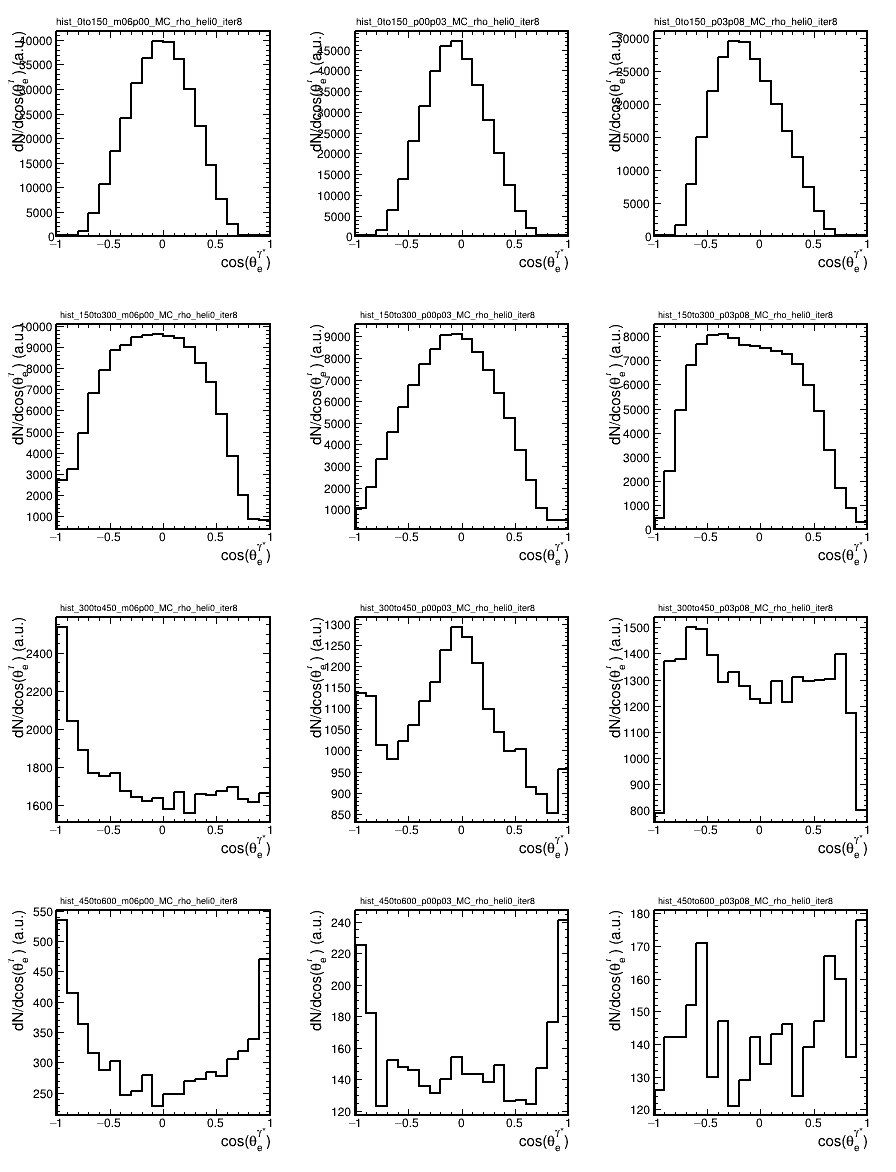

In [6]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    pad = can5.cd(i+1)
    set_pad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


In [7]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [8]:
TH1.SetDefaultSumw2()

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [9]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [10]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-1

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for j in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [11]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 100
num_repeats = 1
num_samples = 20

In [12]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(hist_index = 0):
    global bounds

    def objective(xx):
        def generator(xxx):
            for x in xxx:
                lambda_theta = x

                hists_mc = get_hist_maker_mc(hist_index).make_hists(lambda_theta)
                chi2, ndf = calc_one_chi2(hists_mc[0][hist_index], histsData_np[0][hist_index])
                allHistsMC.append(hists_mc[0][hist_index])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(N_PARAMS)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    print(f"HIST INDEX: {hist_index}")
    for trial in range(num_repeats):
       # print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for j in tqdm(range(num_queries)):
            feasible_incumbents[trial, j] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
           # print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                )
            after_optimize_acqf = time()
           # print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"{DIR_NAME}/incumbents_" + str(hist_index) + ".pth")
    outfile = TFile(f"{DIR_NAME}/out_{hist_index}.root", "RECREATE")
    outfile.cd()
    for histogram in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        histogram.Write()
    for j, hists in enumerate(histsData_np):
        for k, histogram in enumerate(hists):
                histogram.Write()
               # print ("Writing hist: ", j, k, hist)
    outfile.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        acquisition_score = policy(xs.unsqueeze(1))

    lambda_thetas     = train_x.flatten()
    
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, N_PARAMS + 1].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_distribution

In [13]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []
predictive_lower_all = []
predictive_upper_all = []

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        c_sorted = torch.load(f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        train_x_sorted = torch.load(f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        predictive_distribution = torch.load(f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        c_sorted, train_x_sorted, predictive_distribution = fit_bo(HIST_INDEX)
       # print(c_sorted[-5:])
        
        torch.save(c_sorted, f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(train_x_sorted, f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(predictive_distribution, f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    print("AFTER_READING: ", predictive_mean[100], predictive_lower[100], predictive_upper[100])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)
    predictive_lower_all.append(predictive_lower)
    predictive_upper_all.append(predictive_upper)



AFTER_READING:  tensor(0.2756) tensor(0.2182) tensor(0.3330)
AFTER_READING:  tensor(0.1281) tensor(0.0702) tensor(0.1860)
AFTER_READING:  tensor(0.1390) tensor(0.0639) tensor(0.2141)
AFTER_READING:  tensor(0.0169) tensor(-0.0604) tensor(0.0941)
AFTER_READING:  tensor(0.0569) tensor(-0.0207) tensor(0.1345)
AFTER_READING:  tensor(0.0316) tensor(-0.0449) tensor(0.1080)
AFTER_READING:  tensor(0.0232) tensor(-0.0597) tensor(0.1062)
AFTER_READING:  tensor(0.0445) tensor(-0.0375) tensor(0.1265)
AFTER_READING:  tensor(0.0928) tensor(-0.2818) tensor(0.4675)
AFTER_READING:  tensor(0.1143) tensor(-0.2020) tensor(0.4307)
AFTER_READING:  tensor(0.1599) tensor(-0.0723) tensor(0.3922)
AFTER_READING:  tensor(0.1572) tensor(-0.1207) tensor(0.4351)


In [14]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

range  0 100 -2.0 2.0
0. Final result: lambda_theta =  2.0  +-  0.2976320736097042
range  0 100 -2.0 2.0
1. Final result: lambda_theta =  1.7015337944030762  +-  0.35963800295632686
range  0 100 -2.0 2.0
2. Final result: lambda_theta =  1.233572244644165  +-  0.13017921740655322
range  0 100 -2.0 2.0
3. Final result: lambda_theta =  1.0849536657333374  +-  0.03832938418349994
range  0 100 -2.0 2.0
4. Final result: lambda_theta =  1.2979669570922852  +-  0.045159356805785325
range  0 100 -2.0 2.0
5. Final result: lambda_theta =  1.0869964361190796  +-  0.07236076022231432
range  0 100 -2.0 2.0
6. Final result: lambda_theta =  0.7063407301902771  +-  0.034840525740585014
range  0 100 -2.0 2.0
7. Final result: lambda_theta =  0.7847093939781189  +-  0.04522516804310524
range  0 100 -2.0 2.0
8. Final result: lambda_theta =  0.7107892036437988  +-  0.03149113570009535
range  0 100 -2.0 2.0
9. Final result: lambda_theta =  0.5133892297744751  +-  0.06421453852560673
range  0 100 -2.0 2.0
10.

Info in <TCanvas::Print>: gif file results_1702372287/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_7.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_9.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/comparison_10.gif has been created
Info in <TCanvas::Print>: gif f

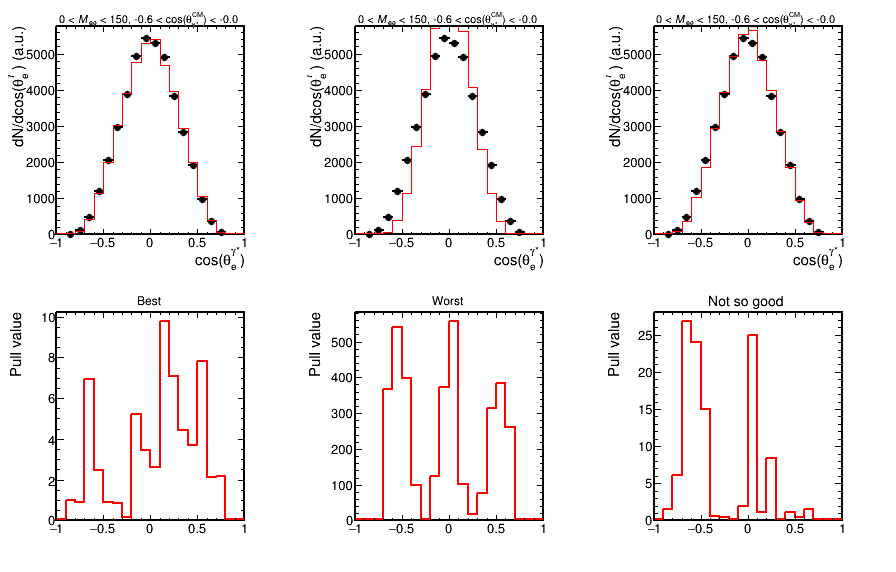

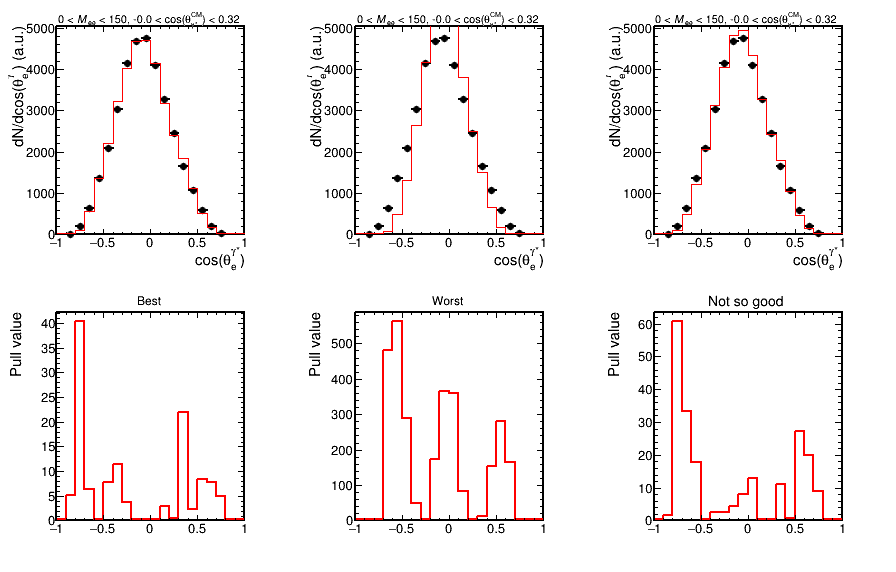

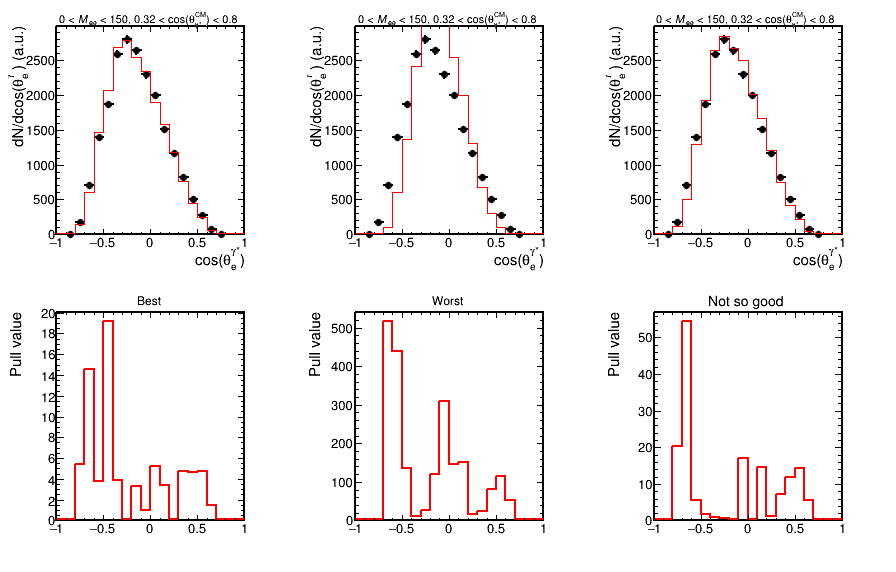

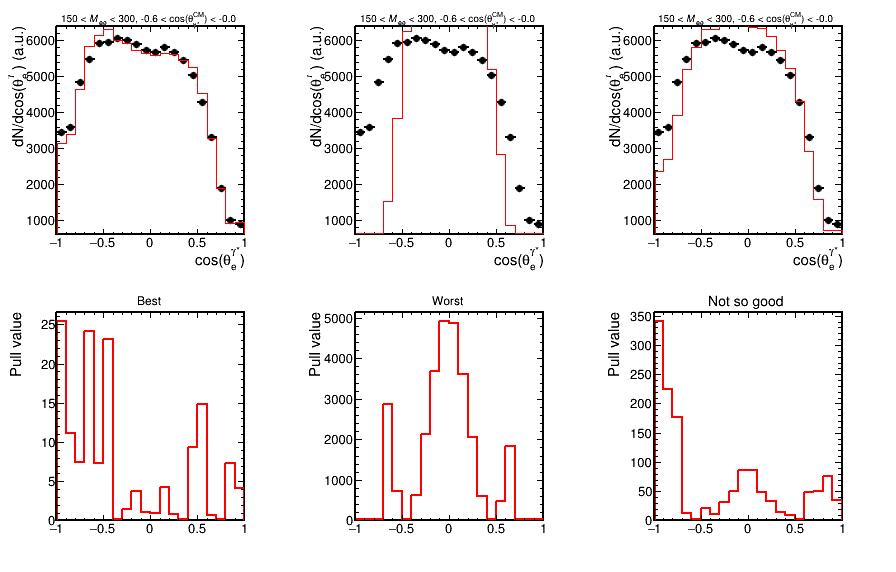

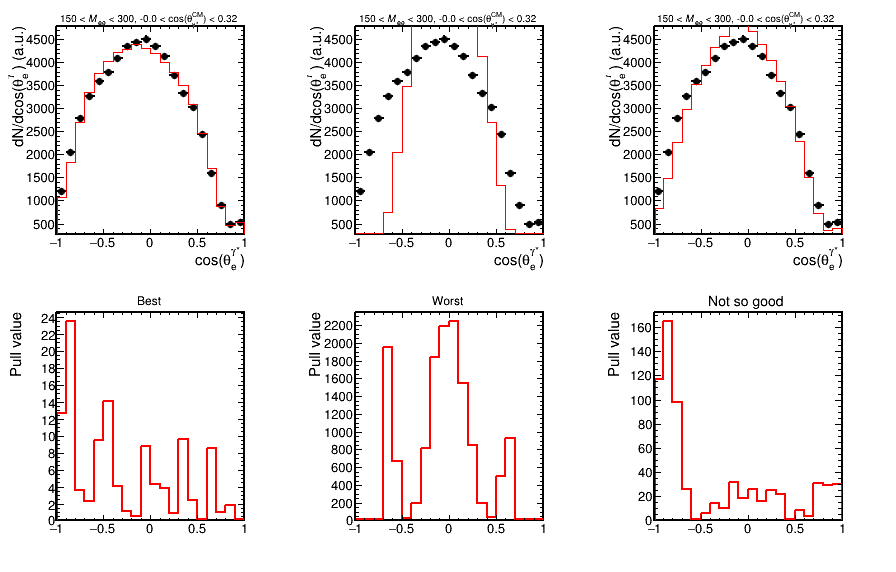

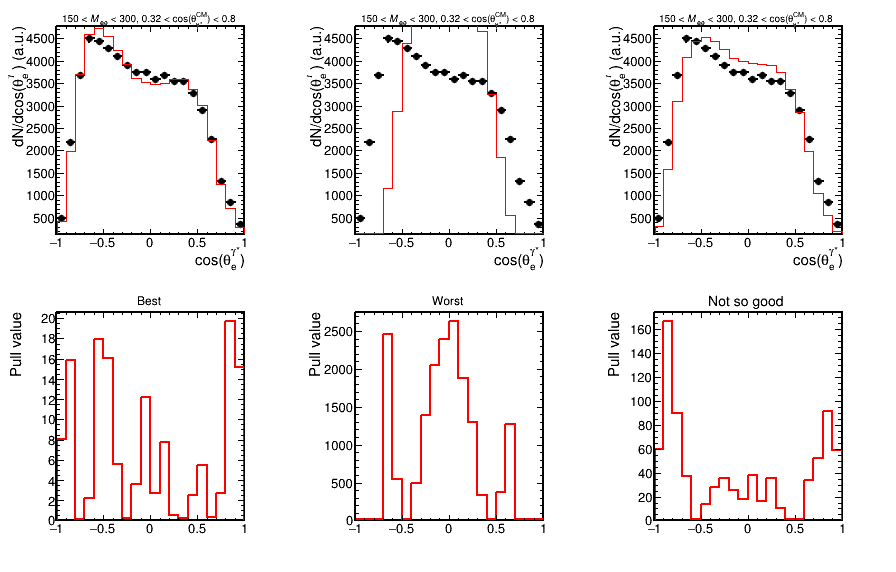

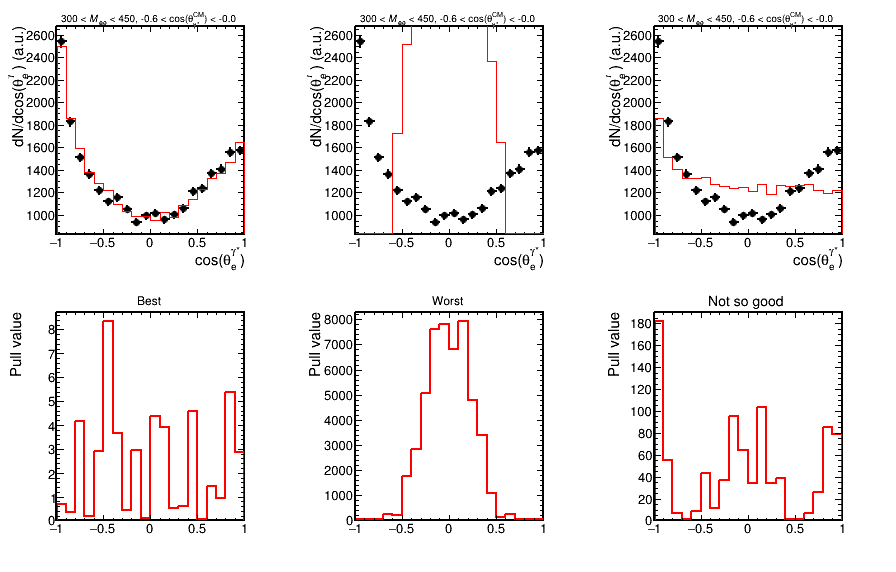

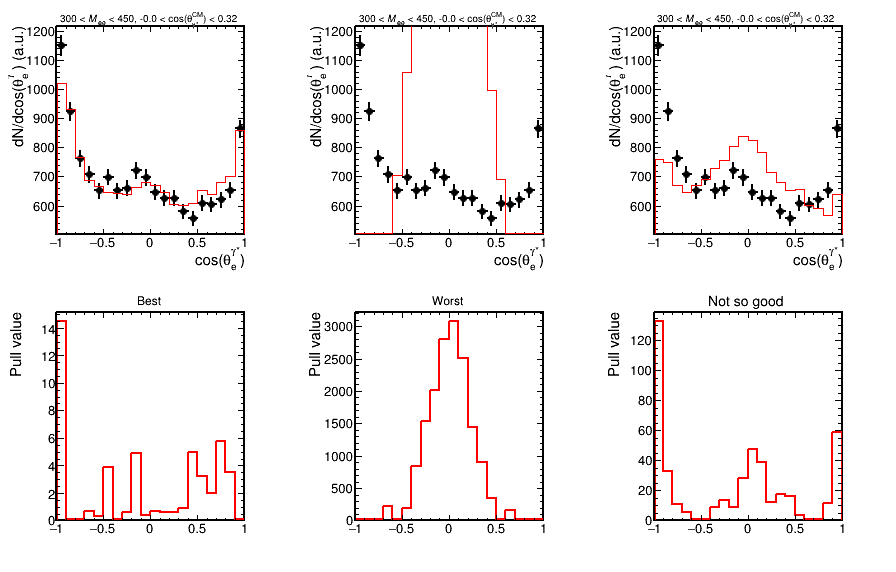

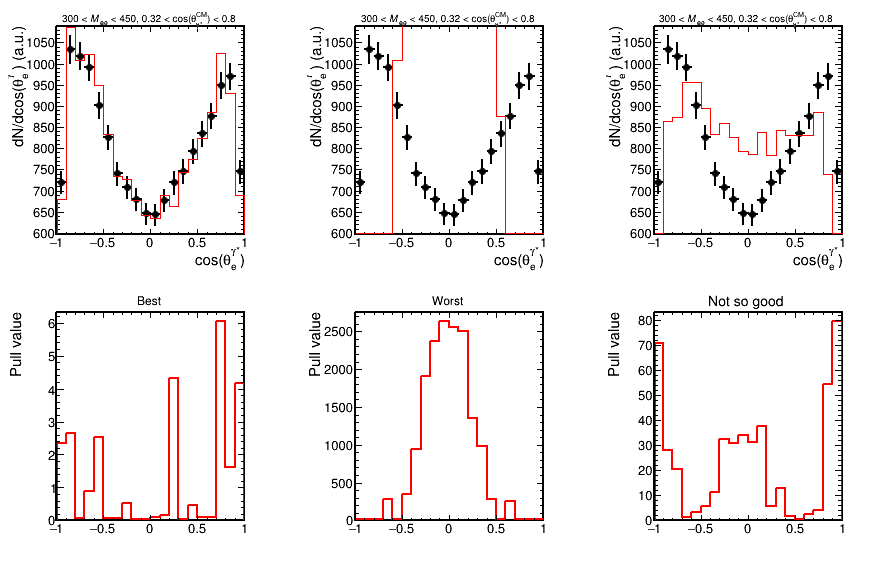

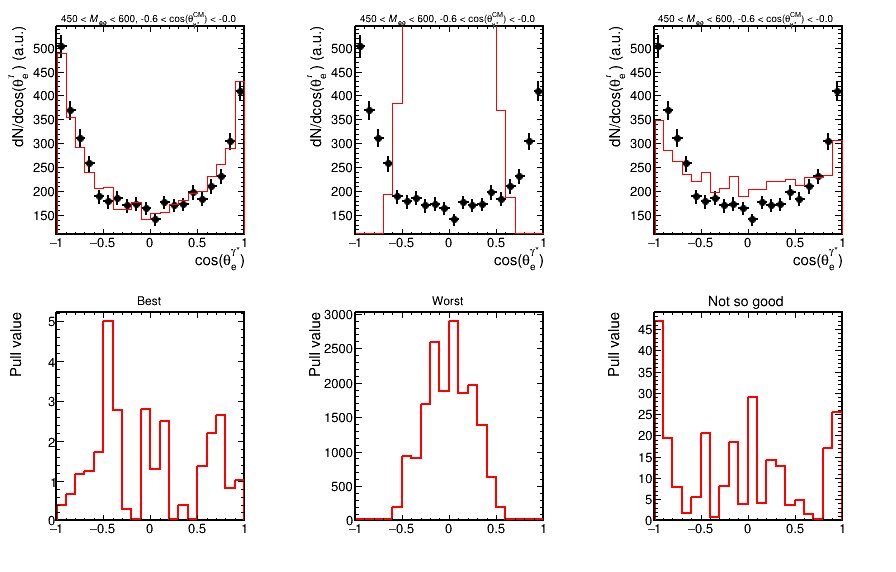

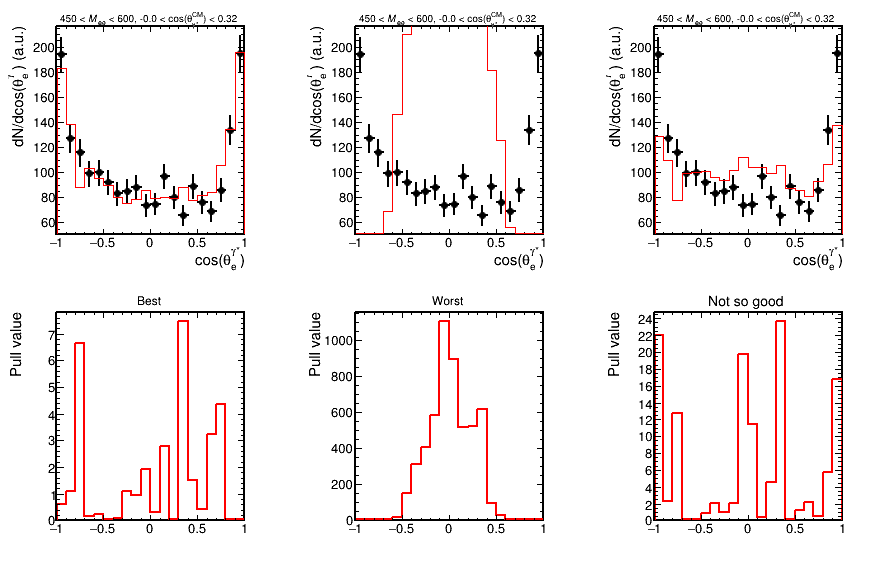

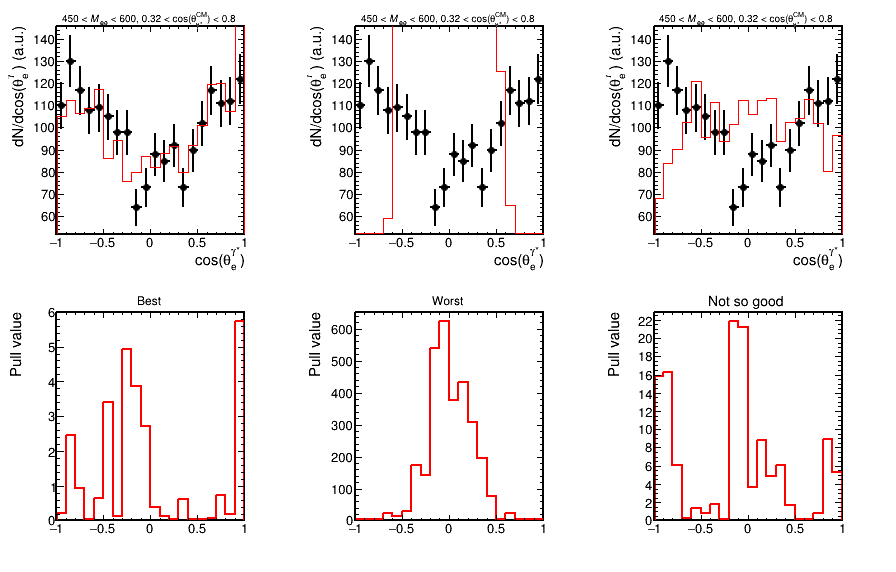

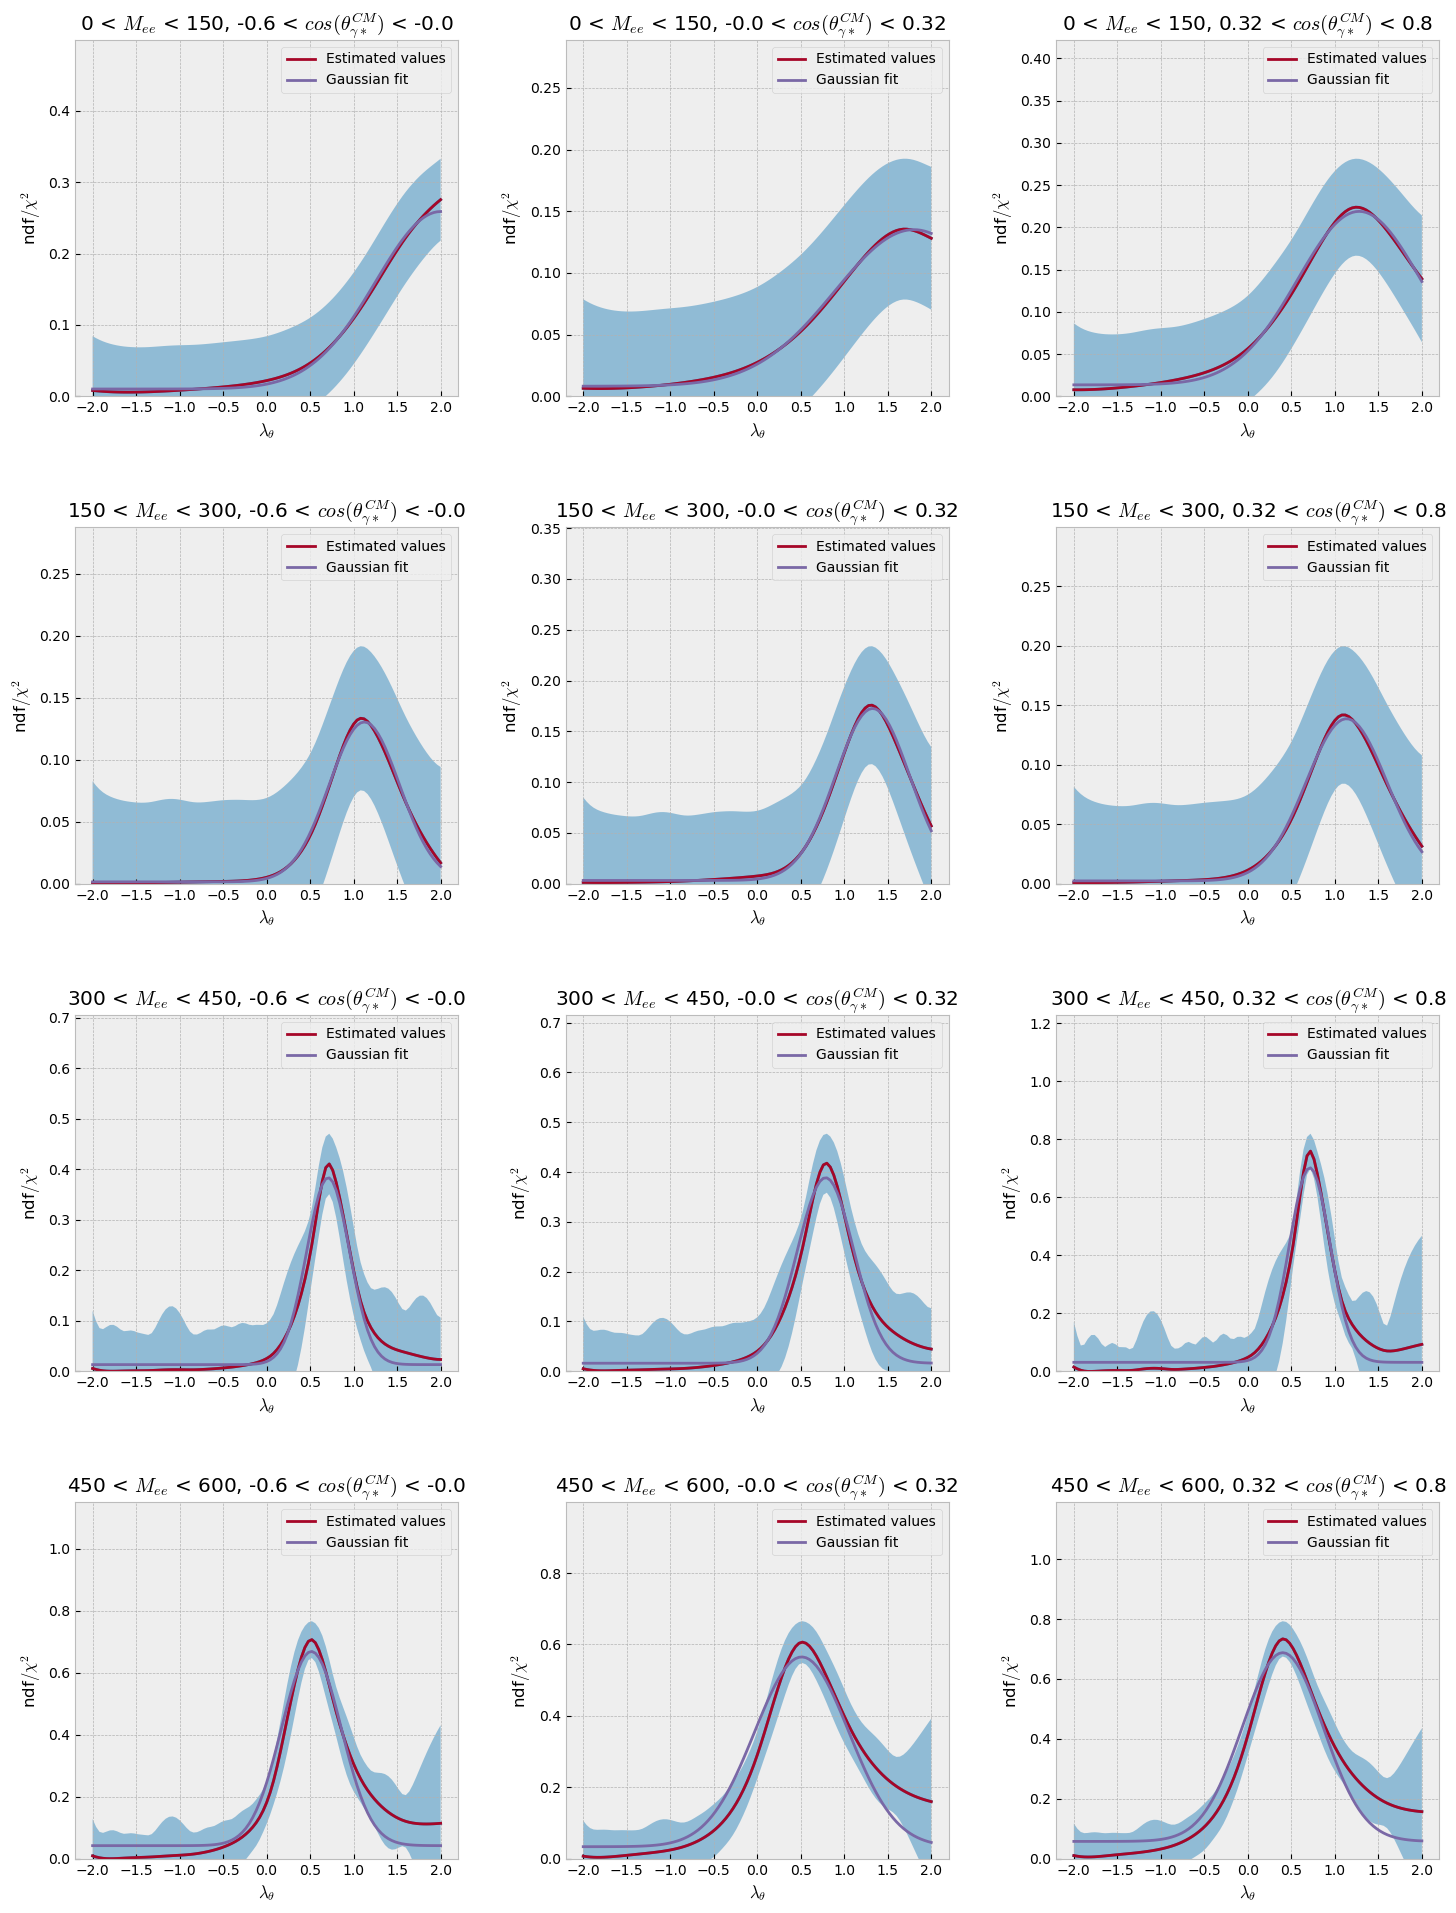

In [15]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    
    fig, ax = plt.subplots(nrows=4, ncols=3)
    fig.tight_layout()
    fig.set_figheight(20)
    fig.set_figwidth(15)
   # fig, ax = plt.subplots(nrows=1, ncols=1)
    
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX - range_used.start]
        train_x_sorted = train_x_sorted_all[HIST_INDEX - range_used.start]
        predictive_mean = predictive_mean_all[HIST_INDEX - range_used.start]
        predictive_lower = predictive_lower_all[HIST_INDEX - range_used.start]
        predictive_upper = predictive_upper_all[HIST_INDEX - range_used.start]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

       # ax = plt.axes()
       # fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = train_x_sorted[-1]
        bestHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",900,600)
        can1.Divide(3,2)
        can1.Draw()        
        canvases.append(can1)
        
        hdiff1 = plotComparison(can1, 1, 4, bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Best", bins)
        hdiffs.append(hdiff1)
        
        lambda_theta = train_x_sorted[0]
        worstHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(worstHistsMC[0][HIST_INDEX])
        hdiff2 = plotComparison(can1, 2, 5, worstHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Worst", bins)
        hdiffs.append(hdiff2)

        shift = 0.75
        if train_x_sorted[-1] > shift - 1:
            diffToBest = torch.tensor([-shift])
        else:
            diffToBest = torch.tensor([+shift])
        lambda_theta = train_x_sorted[-1] + diffToBest
        notSoGoodHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(notSoGoodHistsMC[0][HIST_INDEX])
        hdiff22 = plotComparison(can1, 3, 6, notSoGoodHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Not so good", bins)
        hdiffs.append(hdiff22)

        can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")

        mean, width = covariance_fit_scipy(predictive_mean,predictive_lower,predictive_upper,train_x_sorted[-1],HIST_INDEX,ax[HIST_INDEX // 3][HIST_INDEX % 3], bins, bounds, DIR_NAME)

    
        n, meanX2, varX2, sigma2 = xAxisProperties(bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
        errB0 = math.sqrt(sigma2 * (1/n + meanX2 * meanX2 / varX2))
        errB1 = math.sqrt(sigma2 / varX2)
        ratio_error = ratio_err(c_sorted[-1][1].item(), 1, errB1, errB0)

        try:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), " +- ", ratio_error)
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), " +- ", ratio_error, file=fout)
        except:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item())
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), file=fout)


Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_m06p00_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_m06p00_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_m06p00_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_p00p03_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_p00p03_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_p00p03_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_p03p08_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_p03p08_data_np_iter1_corr (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_0to150_p03p08_data_np_i

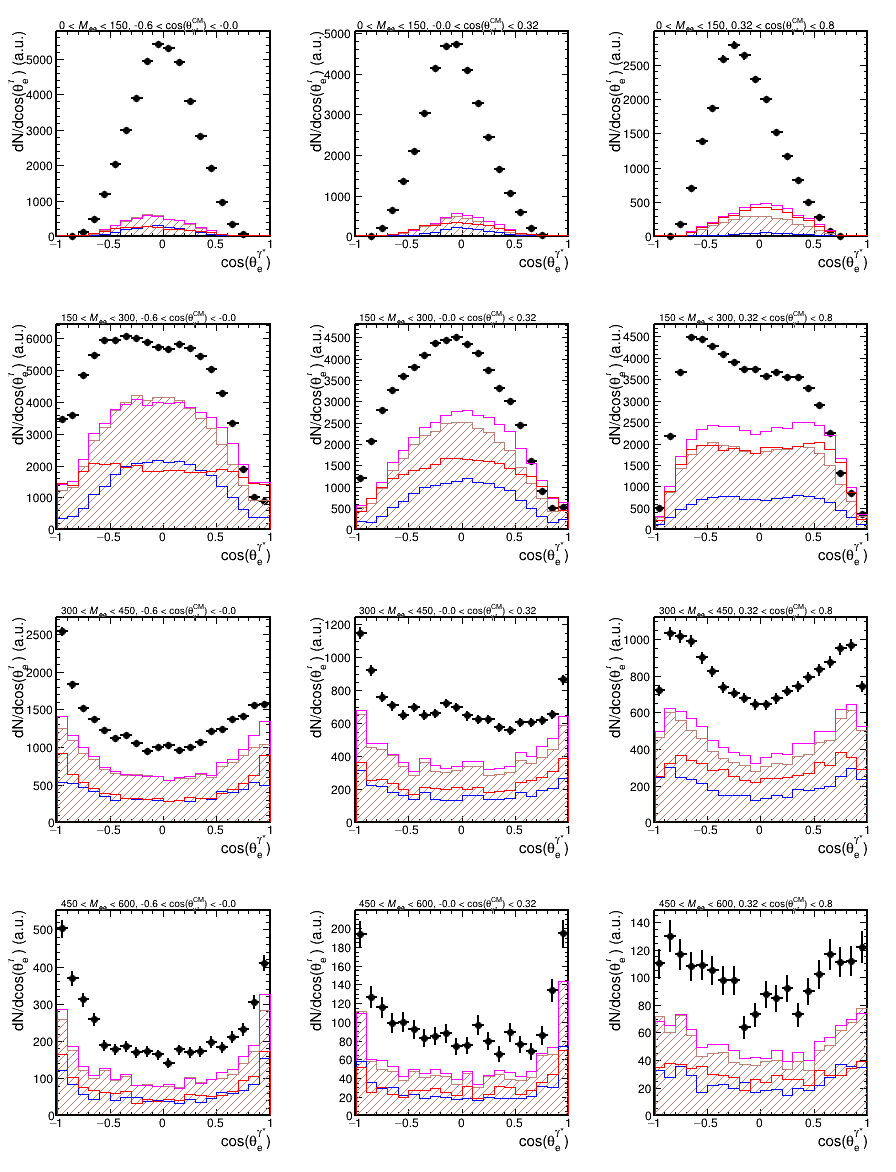

In [16]:
histsDataCorrs = []
histsDatas = []
histsModels = []
hmodel_null = histMakerMC_rho.make_hists((0.0))
hmodel_null_pp = histMakerMC_rho_heli0_pp.make_hists((0.0))
hmodel_null_nn = histMakerMC_rho_heli0_nn.make_hists((0.0))
hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
#hmodel_null_4pi_heli0 = histMakerMC_rho_4pi_heli0.make_hists((0.0))
#hmodel_null_4pi_heli1 = histMakerMC_rho_4pi_heli1.make_hists((0.0))
hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

pol2s = []
paveTexts = []
histsAvg = []
kfactors = []

cc4 = TCanvas("cc4","cc4",900,1200)
cc4.Divide(3,4)
cc4.Draw()

cck = TCanvas("cck","cck",900,1200)
cck.Divide(3,4)

csig = TCanvas("csig","csig",900,1200)
csig.Divide(3,4)

cacc = TCanvas("cacc","cacc",900,1200)
cacc.Divide(3,4)

for i, hist in enumerate(histsData_np[0]):
    
    if not isinstance(hist, list):

        hist_pp = histsData_pp[0][i]
        hist_nn = histsData_nn[0][i]
        
        if symmetrize_explicit:
            symmetrize(hist)
            symmetrize(hist_pp)
            symmetrize(hist_nn)
        
        histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
        histsAvg.append(histAvg)

        
        histCorr = hist.Clone(hist.GetName() + "_corr")
        histCorr_pp = hist_pp.Clone(hist.GetName() + "_corr")
        histCorr_nn = hist_nn.Clone(hist.GetName() + "_corr")
        histsDataCorrs.append(histCorr)
        histsDataCorrs.append(histCorr_pp)
        histsDataCorrs.append(histCorr_nn)
        histCorr.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        pad = cc4.cd(i+1)
        set_pad(pad)       
       
        hist_np_mix = histsData_np_mix[0][i]
        hist_pp_mix = histsData_pp_mix[0][i]
        hist_nn_mix = histsData_nn_mix[0][i]

        if symmetrize_explicit:
            symmetrize(hist_np_mix)
            symmetrize(hist_pp_mix)
            symmetrize(hist_nn_mix)

        histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
        hist_np_mix.Divide(histAvg_mix)
        hist_np_mix.Scale(2)
        kfactors.append(hist_np_mix)

        pad = cck.cd(i+1)
        set_pad(pad)

        hist_np_mix.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        set_th1(hist_np_mix, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist_pp_mix.SetLineColor(2)
        hist_nn_mix.SetLineColor(4)
        hist_pp_mix.SetMarkerColor(2)
        hist_nn_mix.SetMarkerColor(4)
        hist_np_mix.Draw()
        hist_pp_mix.Draw("SAME")
        hist_nn_mix.Draw("SAME")
        hist_np_mix.SetMinimum(0)
         
        pad = cc4.cd(i+1)
        set_pad(pad)       
        
        histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
        histsAvg.append(histAvg_withK)
        histAvg_withK.Multiply(hist_np_mix)
        
        histAvg_withK.SetFillStyle(3004)
        histAvg_withK.SetFillColor(45)
        histAvg_withK.SetLineColor(45)
        histAvg.SetLineColor(6)
        hist_pp.SetLineColor(4)
        hist_nn.SetLineColor(2)
                
        set_th1(hist, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.SetMinimum(0)
        hist.Draw()
        histAvg_withK.Draw("SAMEHIST")
        histAvg.Draw("SAMEHIST")
        hist_pp.Draw("SAMEHIST")
        hist_nn.Draw("SAMEHIST")
        
        pad = csig.cd(i+1)
        set_pad(pad)     

        hist_model = hmodel_null_mix[0][i]
        # TODO: make it consistent if we go the way of using mixing
        hist_model_pp = hmodel_null_mix[0][i]
        hist_model_nn = hmodel_null_mix[0][i]
        if not event_mixing:
            if i < 3:
                hist_model = hmodel_null_pi0[0][i]
                # TODO: make is consisnt if combinatorial background really matters for the pi0 region
                hist_model_pp = hmodel_null_pi0[0][i]
                hist_model_nn = hmodel_null_pi0[0][i]
            else:
                hist_model = hmodel_null[0][i]
                hist_model_pp = hmodel_null_pp[0][i]
                hist_model_nn = hmodel_null_nn[0][i]
        if symmetrize_explicit:
            symmetrize(hist_model)

       # histCorr.Add(histAvg_withK,-1)
        histCorr.Divide(hist_model)
        histCorr_pp.Divide(hist_model_pp)
        histCorr_nn.Divide(hist_model_nn)
        
        histAvgCorr= geom_avg1d(histCorr_pp, histCorr_nn, 0.2)
        histsAvg.append(histAvgCorr)
        histAvgCorr.SetFillStyle(3004)
        histAvgCorr.SetFillColor(45)
        histAvgCorr.SetLineColor(45)
        
        #if symmetrize_explicit:    
            #symmetrize(histCorr)

        fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1.0,1.0)
        fit.SetParameters(1, 1)
        
        histCorr.Fit(fit,"Q")
        pol2s.append(fit)
    
        set_th1(histCorr, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
    
        histCorr_pp.SetLineColor(4)
        histCorr_nn.SetLineColor(2)
        histCorr.Draw()
        histCorr_pp.Draw("SAMEHIST")
        histCorr_nn.Draw("SAMEHIST")
        histAvgCorr.Draw("SAMEHIST")
        if i < 3:
            # histCorr.GetYaxis().SetRangeUser(0,2.5)
            histCorr.GetYaxis().SetRangeUser(0,20)
        else:
            # histCorr.GetYaxis().SetRangeUser(0,1.25)    
            histCorr.GetYaxis().SetRangeUser(0,2)    
        histCorr.SetMinimum(0)
        
        caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
        paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
        paveTexts.append(paveText)

        pad = cacc.cd(i+1)
        set_pad(pad)

        # hacc_heli0 = hist.Clone(hist.GetName() + "_acc_heli0")
        # hacc_heli1 = hist.Clone(hist.GetName() + "_acc_heli1")
        
        hacc_heli0 = hmodel_null[0][i]
        hacc_heli1 = hmodel_null_heli1[0][i]

        #hist_4pi_heli0 = hmodel_null_4pi_heli0[0][i]
        #hist_4pi_heli1 = hmodel_null_4pi_heli1[0][i]
        
        #hacc_heli0.Divide(hist_4pi_heli0)
        #hacc_heli1.Divide(hist_4pi_heli1)
        
        #hacc_heli1.SetMinimum(0)
        #hacc_heli1.Draw("HIST")
        #hacc_heli0.Draw("SAME HIST")

    else:
        print(hist)

cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
    


Info in <TCanvas::Print>: gif file results_1702372287/kfactor.gif has been created
Info in <TCanvas::Print>: gif file results_1702372287/signal.gif has been created


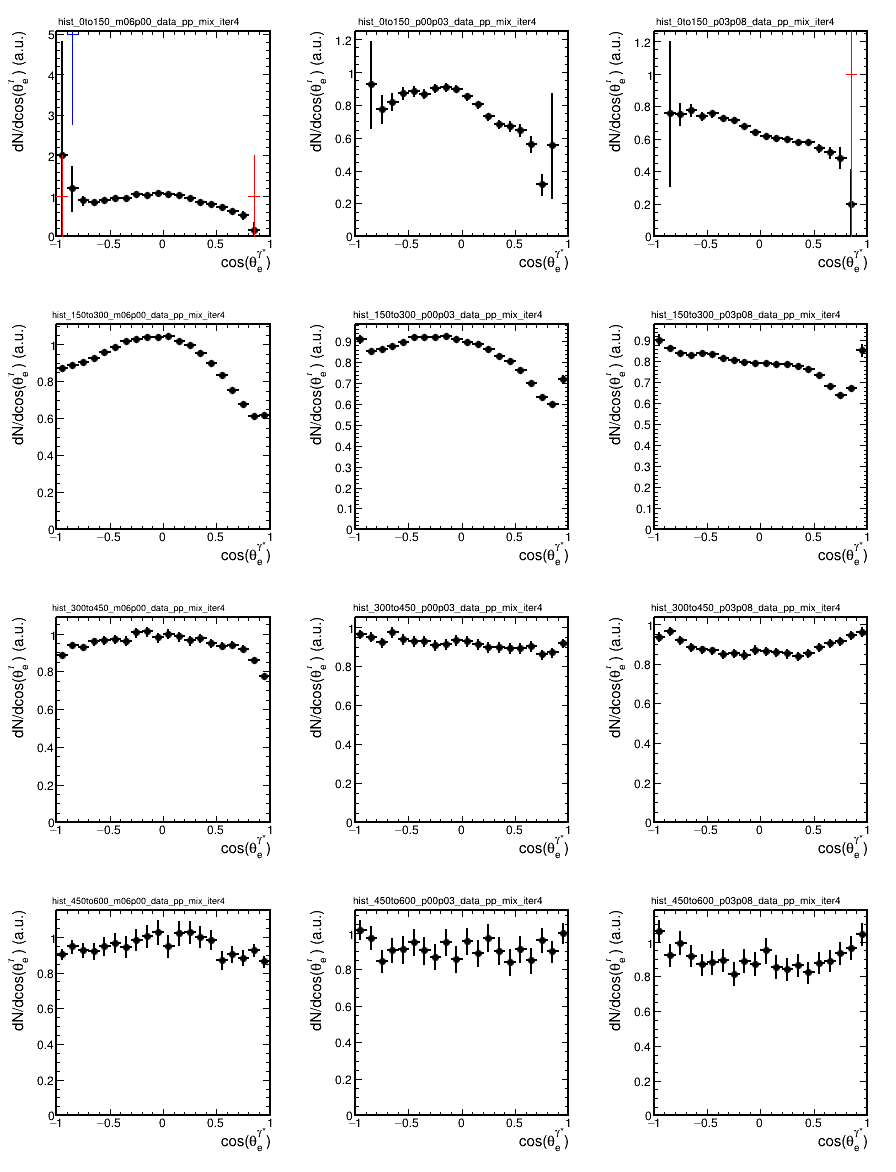

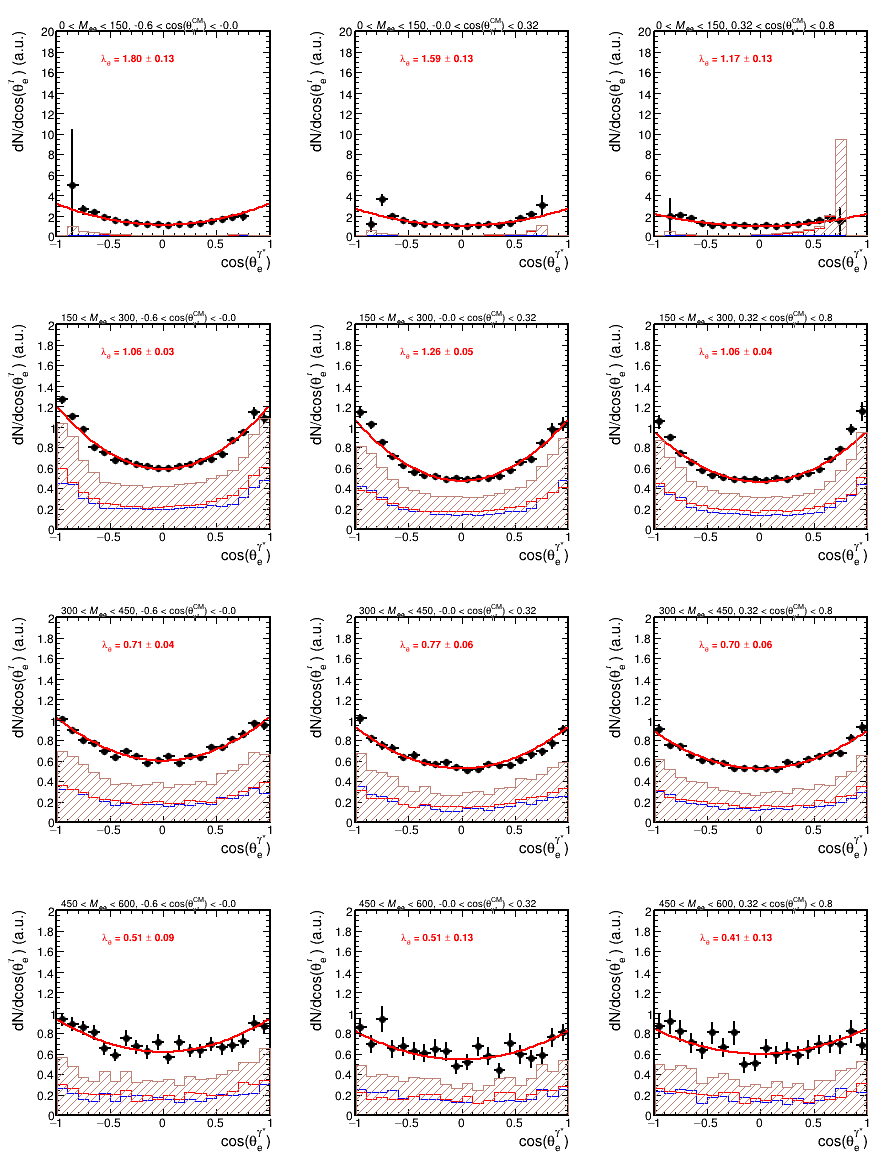

In [17]:
cck.Draw()
cck.SaveAs(f"{DIR_NAME}/kfactor.gif")

csig.Draw()
csig.SaveAs(f"{DIR_NAME}/signal.gif")

Info in <TCanvas::Print>: gif file results_1702372287/cmp_mass_z.gif has been created


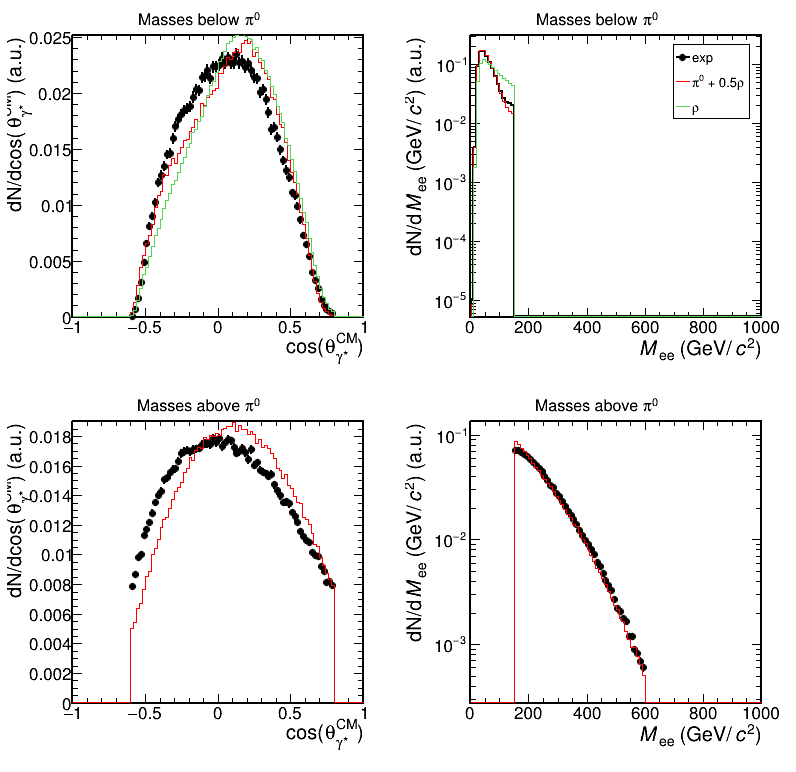

In [18]:
hmodelLowM_rho = histMakerMC_mix.make_hists(0.0) if event_mixing else histMakerMC_rho.make_hists(0.0)
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.make_hists(0.0)

fraction = 0.5

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = get_hist_maker_mc(3).make_hists(0.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

pad = cc.cd(1)
set_pad(pad)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")

set_th1(histsData_np[2][0], histsData_np[2][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
set_pad(pad)
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")

set_th1(histsData_np[1][0], histsData_np[1][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], f"#pi^{{0}} + {fraction}#rho", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

pad = cc.cd(3)
set_pad(pad)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[2][1], histsData_np[2][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
#hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
set_pad(pad)
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[1][1], histsData_np[1][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
#hmodelLowM_rho[1][1].Draw("SAMEHIST")

cc.SaveAs(f"{DIR_NAME}/cmp_mass_z.gif")

ASImage2gif():1010:<results_1702372287/cacc.gif> 
GIF-LIB undefined error 0.
Error in <TASImage::WriteImage>: error writing file results_1702372287/cacc.gif


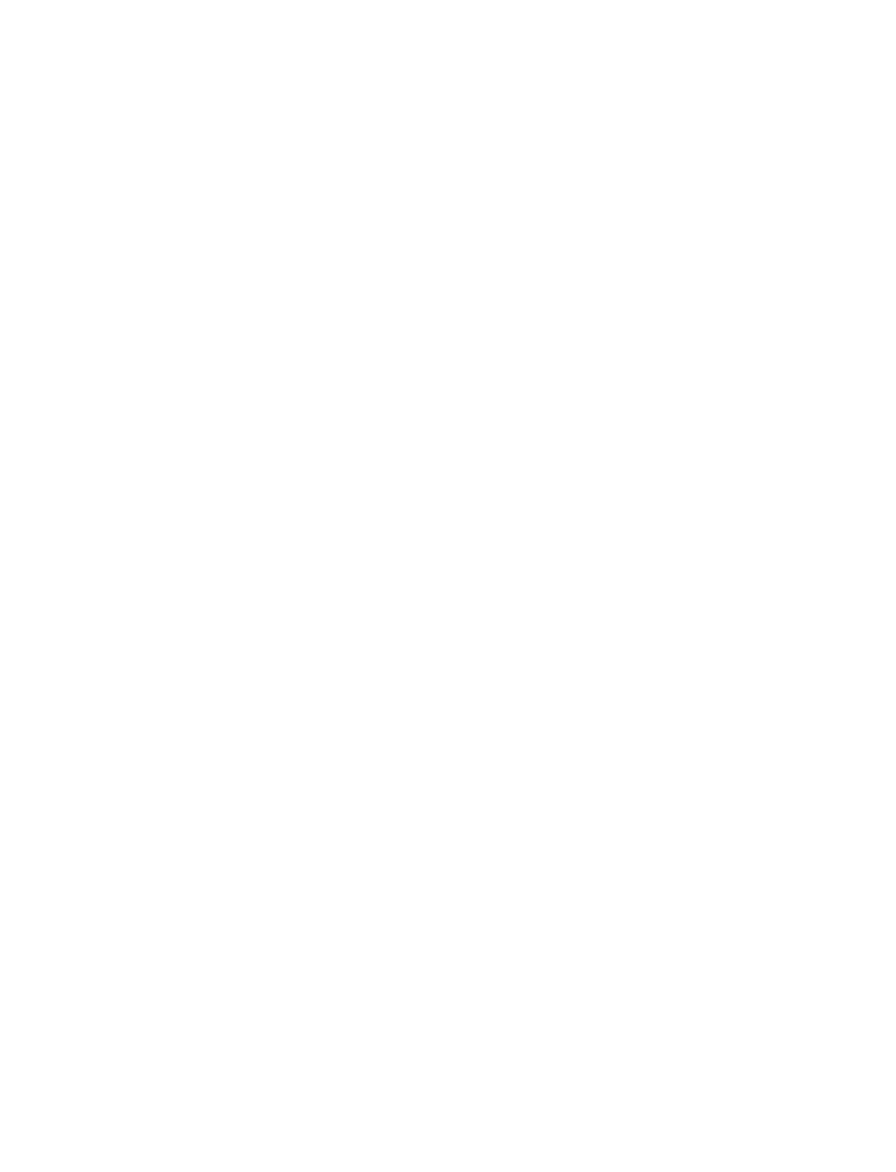

In [19]:
cacc.Draw()
cacc.SaveAs(f"{DIR_NAME}/cacc.gif")

ASImage2gif():1010:<results_1702372287/cacc.gif> 
GIF-LIB undefined error 0.
Error in <TASImage::WriteImage>: error writing file results_1702372287/cacc.gif
